In [1]:
from pathlib import Path 
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from threading import Lock
import re


import pandas as pd 
import numpy as np 




In [2]:
path = Path('../data/')


dataverse_path =  path / 'dataverse_files'


partitions_list = [


    'partition3_instances',

    
    ]



In [3]:

def parse_partition(partions_list, dataverse_path,filename=None, max_workers=3):

    feature_list_summaries = [ 'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH',
       'SAVNCPP', 'USFLUX', 'TOTFZ', 'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45',
       'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY',
       'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE']
    
    descriptors = [
    'Max',
    'Min',
    'Median',
    'Mean',
    'Std',
    'Variance',
    'Skewness',
    'Kurtosis'
        ]
    




    # First pass: collect all files to show total progress
    all_files = []
    for partition_inst in partitions_list:
        partition_inst_path = dataverse_path / partition_inst
        partition_num = partition_inst.replace('_instances', '')
        partition_folder_path = partition_inst_path / partition_num
        
        for folder in ['FL', 'NF']:
            folder_path = partition_folder_path / folder
            if folder_path.exists() and folder_path.is_dir():
                for file in folder_path.glob('*.csv'):
                    all_files.append((file, folder, partition_num))
    



    def parse_file(file_info):
        ''' helper funcrtion to parse individual file 
            scrapes filename for relevant info and returns as dict to append to a df later 


            got a bunch of regexes to take care of the parsing here.
        '''

        


        file, class_label, partition_num = file_info
        filename = file.stem
        
        parsed_info = {
            
            'class': None,
            'flare_id': None,
            'active_region': None,
            'start_time': None,
            'end_time': None,
            
    
        }
        


        def lwma_linear_fast(df, column):
            x = np.asarray(df[column].to_numpy(), dtype=np.float64)
            n = x.size
            if n == 0:
                return np.nan

            i = np.arange(1, n + 1, dtype=np.float64)          # still allocates, but small + fast
            denom = n * (n + 1) / 2.0                          # sum(i)
            return (x @ i) / denom

        def lwma_quadratic_fast(df, column):
            x = np.asarray(df[column].to_numpy(), dtype=np.float64)
            n = x.size
            if n == 0:
                return np.nan

            i = np.arange(1, n + 1, dtype=np.float64)
            denom = n * (n + 1) * (2 * n + 1) / 6.0            # sum(i^2)
            return (x @ (i * i)) / denom
        
        def average_absolute_change(df,column):
            x = df[column].to_numpy()
            return np.mean(np.abs(np.diff(x)))
        
        def last_value(df,column):
            return df[column].iloc[-1]

        def average_absolute_derivative_change(df, column, dt_minutes = 12.0):
            s = pd.to_numeric(df[column], errors="coerce")
            deriv = s.diff() / dt_minutes
            deriv_change = deriv.diff().abs()
            return float(deriv_change.mean())
            






        def calc_summaries(file):
            df = pd.read_csv(
                file,
                sep="\t",
                na_values=["", " ", "NA", "NaN", "null", "None", "inf", "-inf"]
            )

            # force numeric
            df[feature_list_summaries] = df[feature_list_summaries].apply(pd.to_numeric, errors="coerce")

            # treat inf as missing
            df[feature_list_summaries] = df[feature_list_summaries].replace([np.inf, -np.inf], np.nan)

            # interpolate + fill
            df[feature_list_summaries] = (
                df[feature_list_summaries]
                .interpolate(method="linear", axis=0, limit_direction="both")
                .ffill()
                .bfill()
            )

            # if any columns were entirely NaN, set them to 0
            all_nan_cols = df[feature_list_summaries].columns[df[feature_list_summaries].isna().all()]
            if len(all_nan_cols) > 0:
                df[all_nan_cols] = 0.0

            # final hard assert
            if df[feature_list_summaries].isna().any().any():
                bad = df[feature_list_summaries].columns[df[feature_list_summaries].isna().any()].tolist()
                raise ValueError(f"Still have NaNs after fill in columns: {bad}")

            desc_feats = {}
            for feat in feature_list_summaries:
                s = df[feat]
                n = s.notna().sum()

                desc_feats[f"{feat}_Max"] = float(s.max())
                desc_feats[f"{feat}_Min"] = float(s.min())
                desc_feats[f"{feat}_Median"] = float(s.median())
                desc_feats[f"{feat}_Mean"] = float(s.mean())
                desc_feats[f"{feat}_Std_dev"] = float(s.std(ddof=1)) if n > 1 else 0.0
                desc_feats[f"{feat}_Variance"] = float(s.var(ddof=1)) if n > 1 else 0.0
                desc_feats[f"{feat}_Skewness"] = float(s.skew()) if n > 2 else 0.0
                desc_feats[f"{feat}_Kurtosis"] = float(s.kurt()) if n > 3 else 0.0

                # if these helpers can output nan, wrap them too:
                desc_feats[f"{feat}_avg_abs_derivative_change"] = float(np.nan_to_num(average_absolute_derivative_change(df, feat), nan=0.0))
                desc_feats[f"{feat}_last_value"] = float(np.nan_to_num(last_value(df, feat), nan=0.0))
                desc_feats[f"{feat}_average_absolute_change"] = float(np.nan_to_num(average_absolute_change(df, feat), nan=0.0))
                desc_feats[f"{feat}_quadratic_weighted_moving_average"] = float(np.nan_to_num(lwma_quadratic_fast(df, feat), nan=0.0))
                desc_feats[f"{feat}_linear_weighted_moving_average"] = float(np.nan_to_num(lwma_linear_fast(df, feat), nan=0.0))

            return desc_feats


        feature_summaries = calc_summaries(file)

        # Parse filename - handle both FL and NF cases
        if '@' in filename:
            # Format: M1.0@265:Primary_ar115_s2010-08-06T08:36:00_e2010-08-06T20:24:00
            flare_part, rest = filename.split('@', 1)
            parsed_info['class'] = flare_part.strip()[0]
            
            flare_id_part, location_part = rest.split(':', 1)
            parsed_info['flare_id'] = flare_id_part.strip()
            
            # Parse active region and times
            ar_match = re.search(r'_ar(\d+)', location_part)
            if ar_match:
                parsed_info['active_region'] = ar_match.group(1)
            
            start_match = re.search(r'_s(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', location_part)
            if start_match:
                parsed_info['start_time'] = start_match.group(1)
            
            end_match = re.search(r'_e(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', location_part)
            if end_match:
                parsed_info['end_time'] = end_match.group(1)
        else:
            # NF case - parse similar format without flare ID

            parsed_info['class'] = 'NF'
            parsed_info['flare_id'] = 0


            ar_match = re.search(r'_ar(\d+)', filename)
            if ar_match:
                parsed_info['active_region'] = ar_match.group(1)
            
            start_match = re.search(r'_s(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', filename)
            if start_match:
                parsed_info['start_time'] = start_match.group(1)
            
            end_match = re.search(r'_e(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', filename)
            if end_match:
                parsed_info['end_time'] = end_match.group(1)


        
        temp = {**parsed_info,**feature_summaries}

        parsed_info = temp
        return parsed_info
    
    # call threads here ( pls run this threaded )
    all_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(parse_file, file_info): file_info for file_info in all_files}
        
        # TQDM progress bar
        with tqdm(total=len(all_files), desc="Parsing files", unit="file") as pbar:
            for future in as_completed(futures):
                result = future.result()
                all_results.append(result)
                pbar.update(1)
    

    results_df = pd.DataFrame(all_results)
    return results_df
        

            
            
    

    





In [4]:
result = parse_partition(partitions_list, dataverse_path, filename=None)
print(f"\nTotal files parsed: {len(result)}")
result


Parsing files: 100%|██████████| 42510/42510 [36:42<00:00, 19.30file/s]



Total files parsed: 42510


,class,flare_id,active_region,start_time,end_time,TOTUSJH_Max,TOTUSJH_Min,TOTUSJH_Median,TOTUSJH_Mean,TOTUSJH_Std_dev,...,R_VALUE_Mean,R_VALUE_Std_dev,R_VALUE_Variance,R_VALUE_Skewness,R_VALUE_Kurtosis,R_VALUE_avg_abs_derivative_change,R_VALUE_last_value,R_VALUE_average_absolute_change,R_VALUE_quadratic_weighted_moving_average,R_VALUE_linear_weighted_moving_average
0,M,7025,3366,2013-11-12T16:12:00,2013-11-13T04:00:00,4350.649277,4118.376480,4226.909294,4227.494042,58.945367,...,5.257409,0.060914,0.003711,0.123103,-1.382054,0.001643,5.186335,0.012475,5.208395,5.224619
1,M,7599,3686,2014-02-05T22:00:00,2014-02-06T09:48:00,8722.341628,7849.455657,8161.169937,8172.512223,234.807174,...,5.235223,0.082162,0.006751,0.449198,-1.156580,0.001324,5.396841,0.010436,5.304679,5.277076
2,M,7330,3535,2013-12-28T17:48:00,2013-12-29T05:36:00,1756.738793,1297.973837,1540.108116,1558.014745,113.717670,...,4.171940,0.083943,0.007046,0.071457,-0.669051,0.003959,4.245878,0.032439,4.217225,4.200268
3,M,7539,3688,2014-01-31T19:00:00,2014-02-01T06:48:00,2234.206232,1812.025600,1936.642763,1966.858921,111.419294,...,4.172024,0.125432,0.015733,-0.264967,-0.965933,0.004286,4.351332,0.035149,4.199851,4.176571
4,M,8424,4197,2014-06-12T04:24:00,2014-06-12T16:12:00,5971.995387,5427.601612,5685.931906,5676.449862,151.055841,...,5.310882,0.069291,0.004801,0.055277,-1.166496,0.001108,5.413816,0.009224,5.369353,5.349381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42505,C,6930,3336,2013-11-04T03:48:00,2013-11-04T15:36:00,569.166881,465.063842,545.241045,532.860106,26.906501,...,3.269404,0.180812,0.032693,-0.697572,-0.588629,0.010002,3.410434,0.074347,3.282170,3.263614
42506,NF,0,3996,2014-04-11T01:00:00,2014-04-11T12:48:00,1006.345520,844.060934,928.770780,931.624050,39.566040,...,4.876126,0.054204,0.002938,-0.483670,-0.286243,0.002584,4.782547,0.019712,4.833546,4.850094
42507,NF,0,3320,2013-11-04T21:12:00,2013-11-05T09:00:00,67.561541,52.969193,59.883312,60.457297,3.201471,...,0.059618,0.323763,0.104823,5.333765,27.360505,0.005126,1.790846,0.030353,0.171589,0.116305
42508,NF,0,3779,2014-02-22T19:24:00,2014-02-23T07:12:00,1462.443423,1162.371499,1242.814265,1271.082591,88.628283,...,3.120327,0.644102,0.414867,-2.480361,8.643105,0.047216,2.847732,0.319694,2.748649,2.883469


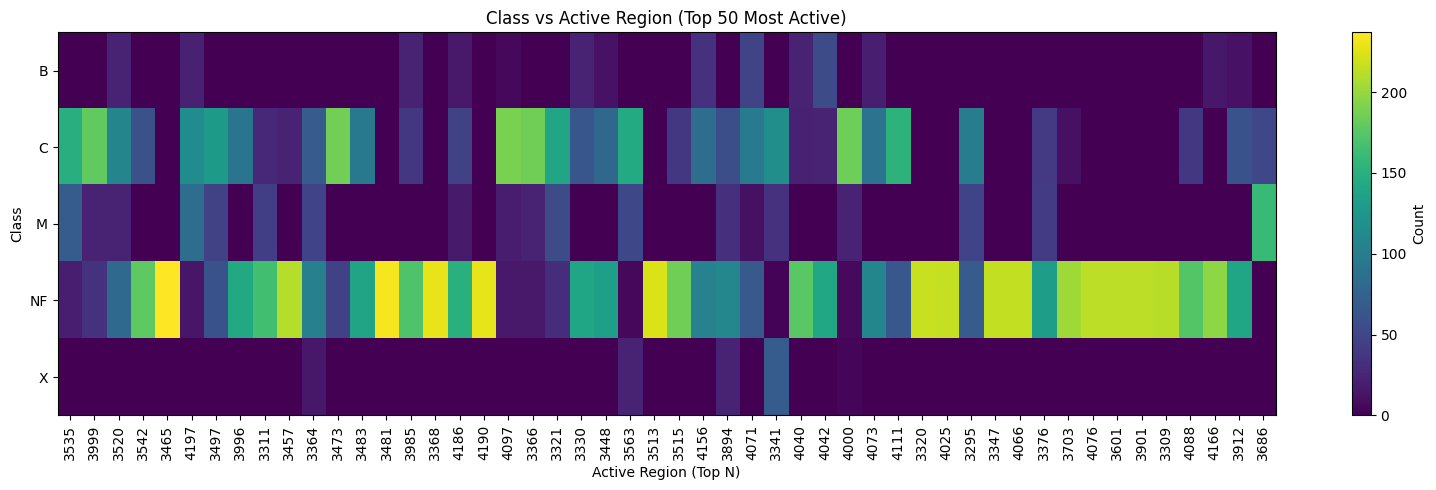

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = result.copy()
df["active_region"] = pd.to_numeric(df["active_region"], errors="coerce")
df = df.dropna(subset=["active_region"])
df["active_region"] = df["active_region"].astype(int)

ct = pd.crosstab(df["class"], df["active_region"])

# pick top N regions by total activity
top_n = 50
top_regions = ct.sum(axis=0).sort_values(ascending=False).head(top_n).index
ct_top = ct[top_regions]

plt.figure(figsize=(16, 5))
plt.imshow(ct_top.values, aspect="auto")
plt.colorbar(label="Count")

plt.yticks(range(ct_top.shape[0]), ct_top.index)
plt.xticks(range(ct_top.shape[1]), ct_top.columns, rotation=90)

plt.xlabel("Active Region (Top N)")
plt.ylabel("Class")
plt.title(f"Class vs Active Region (Top {top_n} Most Active)")
plt.tight_layout()
plt.show()


In [ ]:
#

In [8]:
result.columns

Index(['class', 'flare_id', 'active_region', 'start_time', 'end_time',
       'TOTUSJH_Max', 'TOTUSJH_Min', 'TOTUSJH_Median', 'TOTUSJH_Mean',
       'TOTUSJH_Std_dev',
       ...
       'R_VALUE_Mean', 'R_VALUE_Std_dev', 'R_VALUE_Variance',
       'R_VALUE_Skewness', 'R_VALUE_Kurtosis',
       'R_VALUE_avg_abs_derivative_change', 'R_VALUE_last_value',
       'R_VALUE_average_absolute_change',
       'R_VALUE_quadratic_weighted_moving_average',
       'R_VALUE_linear_weighted_moving_average'],
      dtype='object', length=317)

In [16]:
data_prep = result.copy()

In [17]:
data_prep = data_prep.drop(columns=['flare_id'])

In [18]:
data_prep

,class,active_region,start_time,end_time,TOTUSJH_Max,TOTUSJH_Min,TOTUSJH_Median,TOTUSJH_Mean,TOTUSJH_Std_dev,TOTUSJH_Variance,...,R_VALUE_Mean,R_VALUE_Std_dev,R_VALUE_Variance,R_VALUE_Skewness,R_VALUE_Kurtosis,R_VALUE_avg_abs_derivative_change,R_VALUE_last_value,R_VALUE_average_absolute_change,R_VALUE_quadratic_weighted_moving_average,R_VALUE_linear_weighted_moving_average
0,M,3366,2013-11-12T16:12:00,2013-11-13T04:00:00,4350.649277,4118.376480,4226.909294,4227.494042,58.945367,3474.556250,...,5.257409,0.060914,0.003711,0.123103,-1.382054,0.001643,5.186335,0.012475,5.208395,5.224619
1,M,3686,2014-02-05T22:00:00,2014-02-06T09:48:00,8722.341628,7849.455657,8161.169937,8172.512223,234.807174,55134.408776,...,5.235223,0.082162,0.006751,0.449198,-1.156580,0.001324,5.396841,0.010436,5.304679,5.277076
2,M,3535,2013-12-28T17:48:00,2013-12-29T05:36:00,1756.738793,1297.973837,1540.108116,1558.014745,113.717670,12931.708406,...,4.171940,0.083943,0.007046,0.071457,-0.669051,0.003959,4.245878,0.032439,4.217225,4.200268
3,M,3688,2014-01-31T19:00:00,2014-02-01T06:48:00,2234.206232,1812.025600,1936.642763,1966.858921,111.419294,12414.259087,...,4.172024,0.125432,0.015733,-0.264967,-0.965933,0.004286,4.351332,0.035149,4.199851,4.176571
4,M,4197,2014-06-12T04:24:00,2014-06-12T16:12:00,5971.995387,5427.601612,5685.931906,5676.449862,151.055841,22817.867146,...,5.310882,0.069291,0.004801,0.055277,-1.166496,0.001108,5.413816,0.009224,5.369353,5.349381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42505,C,3336,2013-11-04T03:48:00,2013-11-04T15:36:00,569.166881,465.063842,545.241045,532.860106,26.906501,723.959770,...,3.269404,0.180812,0.032693,-0.697572,-0.588629,0.010002,3.410434,0.074347,3.282170,3.263614
42506,NF,3996,2014-04-11T01:00:00,2014-04-11T12:48:00,1006.345520,844.060934,928.770780,931.624050,39.566040,1565.471495,...,4.876126,0.054204,0.002938,-0.483670,-0.286243,0.002584,4.782547,0.019712,4.833546,4.850094
42507,NF,3320,2013-11-04T21:12:00,2013-11-05T09:00:00,67.561541,52.969193,59.883312,60.457297,3.201471,10.249419,...,0.059618,0.323763,0.104823,5.333765,27.360505,0.005126,1.790846,0.030353,0.171589,0.116305
42508,NF,3779,2014-02-22T19:24:00,2014-02-23T07:12:00,1462.443423,1162.371499,1242.814265,1271.082591,88.628283,7854.972559,...,3.120327,0.644102,0.414867,-2.480361,8.643105,0.047216,2.847732,0.319694,2.748649,2.883469


In [19]:
data_prep['class'] = data_prep['class'].isin(['M','X']).astype(int)

In [20]:
data_prep

,class,active_region,start_time,end_time,TOTUSJH_Max,TOTUSJH_Min,TOTUSJH_Median,TOTUSJH_Mean,TOTUSJH_Std_dev,TOTUSJH_Variance,...,R_VALUE_Mean,R_VALUE_Std_dev,R_VALUE_Variance,R_VALUE_Skewness,R_VALUE_Kurtosis,R_VALUE_avg_abs_derivative_change,R_VALUE_last_value,R_VALUE_average_absolute_change,R_VALUE_quadratic_weighted_moving_average,R_VALUE_linear_weighted_moving_average
0,1,3366,2013-11-12T16:12:00,2013-11-13T04:00:00,4350.649277,4118.376480,4226.909294,4227.494042,58.945367,3474.556250,...,5.257409,0.060914,0.003711,0.123103,-1.382054,0.001643,5.186335,0.012475,5.208395,5.224619
1,1,3686,2014-02-05T22:00:00,2014-02-06T09:48:00,8722.341628,7849.455657,8161.169937,8172.512223,234.807174,55134.408776,...,5.235223,0.082162,0.006751,0.449198,-1.156580,0.001324,5.396841,0.010436,5.304679,5.277076
2,1,3535,2013-12-28T17:48:00,2013-12-29T05:36:00,1756.738793,1297.973837,1540.108116,1558.014745,113.717670,12931.708406,...,4.171940,0.083943,0.007046,0.071457,-0.669051,0.003959,4.245878,0.032439,4.217225,4.200268
3,1,3688,2014-01-31T19:00:00,2014-02-01T06:48:00,2234.206232,1812.025600,1936.642763,1966.858921,111.419294,12414.259087,...,4.172024,0.125432,0.015733,-0.264967,-0.965933,0.004286,4.351332,0.035149,4.199851,4.176571
4,1,4197,2014-06-12T04:24:00,2014-06-12T16:12:00,5971.995387,5427.601612,5685.931906,5676.449862,151.055841,22817.867146,...,5.310882,0.069291,0.004801,0.055277,-1.166496,0.001108,5.413816,0.009224,5.369353,5.349381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42505,0,3336,2013-11-04T03:48:00,2013-11-04T15:36:00,569.166881,465.063842,545.241045,532.860106,26.906501,723.959770,...,3.269404,0.180812,0.032693,-0.697572,-0.588629,0.010002,3.410434,0.074347,3.282170,3.263614
42506,0,3996,2014-04-11T01:00:00,2014-04-11T12:48:00,1006.345520,844.060934,928.770780,931.624050,39.566040,1565.471495,...,4.876126,0.054204,0.002938,-0.483670,-0.286243,0.002584,4.782547,0.019712,4.833546,4.850094
42507,0,3320,2013-11-04T21:12:00,2013-11-05T09:00:00,67.561541,52.969193,59.883312,60.457297,3.201471,10.249419,...,0.059618,0.323763,0.104823,5.333765,27.360505,0.005126,1.790846,0.030353,0.171589,0.116305
42508,0,3779,2014-02-22T19:24:00,2014-02-23T07:12:00,1462.443423,1162.371499,1242.814265,1271.082591,88.628283,7854.972559,...,3.120327,0.644102,0.414867,-2.480361,8.643105,0.047216,2.847732,0.319694,2.748649,2.883469


In [21]:
data_prep.to_csv('../data/ABT.csv',index=False)